<a href="https://colab.research.google.com/github/CP2J/cp2j/blob/ACJ-10-MF-ALS/MF_by_ALS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alternating Least Square (ALS)를 활용한 Matrix Factorization
- ALS의 메인 아이디어는 MF에 사용되는 사용자와 아이템 잠재벡터 이렇게 두 종류의 파라미터를 서로 번갈아가면서 업데이트를 한다는 것
- 즉, P와 Q 중 하나를 고정해놓고 다른 하나를 업데이트하는 방식
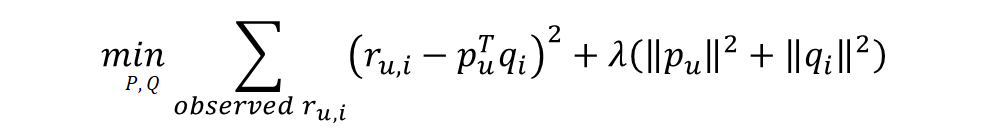
- ALS의 목적함수이며 SGD MF와 완전히 동일하다. 그러나 여기서 하나를 상수로 고정한 후 최적화 문제를 풀게 된다면 이는 선형회귀 문제가 된다. 그리고 선형회귀 문제는 SGD와 다르게 주어진 값들을 바탕으로 OLS Formula를 통해 최적의 값을 한번에 도출할 수 있다. 
(https://sungkee-book.tistory.com/13)

# 1. Import necessary modules and classes

In [1]:
%matplotlib inline
from datetime import datetime
from functools import reduce
from os.path import exists
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

- 레퍼런스의 협업필터링 유틸코드 업로드, Damper Baseline import

In [2]:
from google.colab import files
src = list(files.upload().values())[0]
open('cf_utils.py','wb').write(src)
import cf_utils
# Import User + Movie baseline model : cf_utils.py를 수동으로 업로드 해준다.
from cf_utils import DampedUserMovieBaselineModel

Saving cf_utils.py to cf_utils.py


# 2. Load the Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 시간순 정렬
ratings_df = pd.read_csv('/content/drive/MyDrive/ml-100k/u.data', sep='\t', header=None, 
                         names=['userId', 'movieId', 'rating', 'timestamp'])
ratings_df['timestamp'] = ratings_df['timestamp'].apply(datetime.fromtimestamp)
ratings_df = ratings_df.sort_values('timestamp')
print('First 5:')
display(ratings_df.head())
print()
print('Last 5:')
display(ratings_df.tail())

First 5:


,userId,movieId,rating,timestamp
214,259,255,4,1997-09-20 03:05:10
83965,259,286,4,1997-09-20 03:05:27
43027,259,298,4,1997-09-20 03:05:54
21396,259,185,4,1997-09-20 03:06:21
82655,259,173,4,1997-09-20 03:07:23



Last 5:


,userId,movieId,rating,timestamp
46773,729,689,4,1998-04-22 23:10:38
73008,729,313,3,1998-04-22 23:10:38
46574,729,328,3,1998-04-22 23:10:38
64312,729,748,4,1998-04-22 23:10:38
79208,729,272,4,1998-04-22 23:10:38


# 3. Write helper function(index 매핑) and ALSRecommender class(fit, predict)

In [5]:
user_col, item_col, rating_col = ratings_df.columns[:3]

In [6]:
ratings_df

,userId,movieId,rating,timestamp
214,259,255,4,1997-09-20 03:05:10
83965,259,286,4,1997-09-20 03:05:27
43027,259,298,4,1997-09-20 03:05:54
21396,259,185,4,1997-09-20 03:06:21
82655,259,173,4,1997-09-20 03:07:23
...,...,...,...,...
46773,729,689,4,1998-04-22 23:10:38
73008,729,313,3,1998-04-22 23:10:38
46574,729,328,3,1998-04-22 23:10:38
64312,729,748,4,1998-04-22 23:10:38


In [7]:
item_col

'movieId'

In [8]:
def get_rating_matrix(X):
    '''Rating matrix와 user, item id - row, column indices mapping을 만듦(결론적으로 인덱스(id)-1 의 정수를 매핑)
    Parameters
    ----------
    X : pandas.DataFrame, shape=(n_ratings,>=3)
        First 3 columns must be in order of user, item, rating.

    Returns
    -------
    rating_matrix : 2d numpy array, shape=(n_users, n_items)
    user_map : pandas Series, shape=(n_users,)
        Mapping from the original user id to an integer in the range [0,n_users)
    item_map : pandas Series, shape=(n_items,)
        Mapping from the original item id to an integer in the range [0,n_items)
    '''
    user_col, item_col, rating_col = X.columns[:3] # 세 변수에 처음 세 칼럼명을 할당
    rating = X[rating_col]
    #numpy 모듈의 arange 함수는 반열린구간 [start, stop) 에서 step 의 크기만큼 일정하게 떨어져 있는 숫자들을 array 형태로 반환
    user_map = pd.Series(
        index = np.unique(X[user_col]), # 고유한 원소들(user_id)을 모은 뒤, 오름차순 정렬한 결과(array)를 반환
        data = np.arange(X[user_col].nunique()), # nunique는 고유한 요소의 수(user_id수), 그걸 0부터 요소수-1 까지 배열로 만듦. [0, n_users-1]
        name = 'user_map',
    )
    item_map = pd.Series(
        index = np.unique(X[item_col]), # unique item_id
        data = np.arange(X[item_col].nunique()), # integer in the range [0,n_items)
        name = 'item_map',
    )
    # map(적용시킬 함수, 적용할 값들) : 반복 가능한 자료형 (리스트나 튜플)을 첫 번째 인자로 들어온 함수에 하나씩 집어넣어서 함수를 수행
    user_inds = X[user_col].map(user_map) # 각 user_id(=row index)에 [0, n_users-1] mapping
    item_inds = X[item_col].map(item_map)
    rating_matrix = (
        pd.pivot_table(
            data=X,
            values=rating_col,
            index=user_inds,
            columns=item_inds,
        )
        .fillna(0)
        .values
    )
    return rating_matrix, user_map, item_map

In [9]:
get_rating_matrix(ratings_df)

(array([[5., 3., 4., ..., 0., 0., 0.],
        [4., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [5., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 5., 0., ..., 0., 0., 0.]]),
 1        0
 2        1
 3        2
 4        3
 5        4
       ... 
 939    938
 940    939
 941    940
 942    941
 943    942
 Name: user_map, Length: 943, dtype: int64,
 1          0
 2          1
 3          2
 4          3
 5          4
         ... 
 1678    1677
 1679    1678
 1680    1679
 1681    1680
 1682    1681
 Name: item_map, Length: 1682, dtype: int64)

In [10]:
class ALSRecommender():
    """Alternating Least Squares algorithm을 이용한 Recommender
    Parameters
    ----------
    k : int, default=5
        Number of latent features(잠재특성 수)
    lmbda : float, default=0.1
        Regularization parameter(L2 규제계수?)
    max_epochs : int, default=15
        Max number of iterations to run
    baseline_algo : object
        Object with fit(X) and 
    """
    # 학습을 초기화시키는 생성자
    def __init__(self, k=5, lmbda=0.1, max_epochs=15, baseline_algo=None, error_metric='mae', verbose=True):
        # float으로 오는 경우에 대비해 integer 지정
        self.k = int(np.round(k))
        self.lmbda = lmbda
        self.max_epochs = max_epochs
        self.baseline_algo = baseline_algo
        self.error_metric = error_metric
        self.verbose = verbose

        self.U = None
        self.I = None
        self.initialized = False

    def _calc_train_error(self, U, I, R, R_selector=None, error_metric='rmse'): # 원 코드는 mae
        if R_selector is None: # 이게 뭐지? 실제 평점?
            R_selector = (R>0)
        R_hat = np.dot(U.T, I) # 예측평점행렬(R_hat)을 구할 때 note에선 U*I.T 했는데, 여기선 U.T*I
        if error_metric == 'rmse':
            error = np.sqrt( np.sum( R_selector * (R_hat - R)**2 ) / np.sum(R_selector) )
        # if error_metric == 'mae':
        #     error = np.sum( R_selector * np.abs(R_hat - R) ) / np.sum(R_selector)
        else:
            raise ValueError("{} is an unsupprted error metric".format(metric))
        return error

    def _fit_init(self, X):
        if not isinstance(X, pd.DataFrame):   # Dataframe인지 확인
            raise ValueError("X must be a DataFrame")
        X = X.copy()
        user_col, item_col, rating_col = X.columns[:3]
        if self.baseline_algo is None:
            self.train_mean = X[rating_col].mean()    #베이스라인이 없으면 단순평균
        else:
            self.baseline_algo.fit(X)
        self.R, self.user_map, self.item_map = get_rating_matrix(X)
        n_users, n_items = self.R.shape
        self.U = 3 * np.random.rand(self.k, n_users)    # 유저 잠재행렬 초기화, 난수 어레이 shape은 주어진 값에 의해 결정되며, 값은 [0, 1) 범위 균일한 분포
        self.I = 3 * np.random.rand(self.k, n_items)    # 아이템 잠재행렬 초기화
        self.I[0, :] = self.R[self.R != 0].mean(axis=0) # 첫번째 열에 각 영화의 평균 평점 저장
        self.E = np.eye(self.k) # k-dimensional identity matrix (단위행렬 : 대각성분이 1, 나머지는 0), np.identity(self.k)와 동일
        self.epoch = 0          # 1 epoch : 인공 신경망이 전체 데이터 셋에 대해 한번의 학습(forward pass/backward pass) 과정을 완료한 것
        self.train_errors = []
        self.initialized = True

    def fit(self, X, n_epochs=None):
        """data X를 학습하기 위해 모델을 만든다(fit). 만약 최소 한번의 iteration이 수행됐다면, 모델은 가장 최근 상태에서 재개함.
        
        Parameters
        ----------
        X : pandas DataFrame, shape=(n_ratings, >=3)
            First 3 columns must correspond to user, item, and rating in that order
        n_epochs : int, optional
            Number of iterations to run. If not provided, will run for self.max_epochs

        Returns
        -------
        self
            This allows chaining like `ALSRecommender().fit(X_train).predict(X_test)`
        """
        # n_epochs가 주어진다면 previous state에서 재개를 허용하고, 아니라면 아예 처음부터 시작.
        if n_epochs is None:
            self.initialized = False              # 새로 시작 여부 변수
        if not self.initialized:                  # 초기화 안되있다면 초기화 한다.
            self._fit_init(X)                     # 수행후 self.initialized = True 될 것.

        epoch_0 = self.epoch                      # epoch_0 = 현재 epoch
        if n_epochs is None:
            n_epochs = self.max_epochs - epoch_0  # n_epochs = max_epochs - 현재 epoch

        n_users, n_items = self.R.shape           # rating_matrix : 2d numpy array, shape=(n_users, n_items)

        # Run n_epochs iterations
        for i_epoch in range(n_epochs):
            if self.epoch >= self.max_epochs:
                print("max_epochs = {}".format(self.max_epochs))
                break
            # Fix I and estimate U (아이템 고정, 유저 추정)
            for i, Ri in enumerate(self.R):                     # Ri : _fit_init에서 만든 user(row)-movie(col) rating matrix의 행(array)
                nui = np.count_nonzero(Ri)                      # nui : user i가 평가한 평점들의 개수(rating matrix는 0으로 결측치 채움)
                if (nui == 0): nui = 1                          # Be aware of zero counts! (하나도 평가 안했을 수도 있다)
                # Get array of nonzero indices in row Ri : user i의 평점(Ri) 중 0 아닌 요소들의 인덱스(nonzero 함수는 요소들 중 0이 아닌 값들의 index 들을 반환)
                Ri_nonzero_selector = np.nonzero(Ri)[0]
                # Select subset of I associated with movies reviewed by user i : 아이템분해행렬(I)에서 user i 가 평가한 영화들의 평점들만 선택 = qi.T
                I_Ri = self.I[:, Ri_nonzero_selector]
                # Select subset of row Ri associated with movies reviewed by user i : 평점매트릭스(R)에서 user i가 평가한 영화들의 평점들 = r_u,i
                Ri_nonzero = self.R[i, Ri_nonzero_selector]
                # $(Q^TQ +\lambda I)^{-1}$
                Ai = np.dot(I_Ri, I_Ri.T) + self.lmbda * nui * self.E
                # $Q^Tr_u$
                Vi = np.dot(I_Ri, Ri_nonzero.T)
                # $p_u = (Q^TQ +\lambda I)^{-1}Q^Tr_u$
                self.U[:, i] = np.linalg.solve(Ai, Vi)

            # Fix U and estimate I
            for j, Rj in enumerate(self.R.T):                    # Rj : rating_matrix를 transpose한 행 (item row 평점)
                nmj = np.count_nonzero(Rj)                       # nmj : Number of users that rated item j
                if (nmj == 0): nmj = 1                           # Be aware of zero counts! (하나도 평가 안했을 수도 있다)
                # Get array of nonzero indices in row Rj : item j의 평점(Rj) 중 0 아닌 요소들의 인덱스
                Rj_nonzero_selector = np.nonzero(Rj)[0]
                # Select subset of P associated with users who reviewed movie j : 유저분해행렬(U=P)에서 item j를 평가한 user들의 평점들만 선택 = pu
                U_Rj = self.U[:, Rj_nonzero_selector]
                # Select subset of column R_j associated with users who reviewed movie j : 평점매트릭스(R)에서 item j를 평가한 user들의 평점들 = r_u,i
                Rj_nonzero = self.R[Rj_nonzero_selector, j]
                # $(P^TP +\lambda I)^{-1}$
                Aj = np.dot(U_Rj, U_Rj.T) + self.lmbda * nmj * self.E
                # $P^Tr_i$
                Vj = np.dot(U_Rj, Rj_nonzero)
                # $q_i = (P^TP +\lambda I)^{-1}P^Tr_i$
                self.I[:, j] = np.linalg.solve(Aj, Vj)

            error = self._calc_train_error(self.U, self.I, self.R) # RMSE, 원 코드는 MAE
            self.train_errors.append(error)
            if self.verbose: # 함수 인자로 verbose가 있으면 함수 수행시 발생하는 상세한 정보들을 표준 출력으로 자세히 내보낼 것인가를 나타냄
                print("[Epoch {}/{}] train error: {}".format(self.epoch, self.max_epochs, error))
            self.epoch += 1
        return self

    def predict(self, X):
        """Generate predictions for user/item pairs
        
        Parameters
        ----------
        X : pandas dataframe, shape = (n_pairs, 2)
            User, item dataframe
            
        Returns
        -------
        rating_pred : 1d numpy array, shape = (n_pairs,)
            Array of rating predictions for each user/item pair
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        X = X.copy()
        user_col, item_col = X.columns[:2]
        # 베이스라인 모델로 예측한 평점을 한 칼럼에 넣어둔다.
        if self.baseline_algo is None:
            X['rating_baseline'] = self.train_mean
        else:
            X['rating_baseline'] = self.baseline_algo.predict(X)
        # 평가할 데이터프레임의 rating 칼럼을 0으로 초기화한다.
        X['rating'] = 0
        # user와 item이 데이터프레임에 있는지 확인하기 위한 변수
        known_user_and_item_mask = (
            X[user_col].isin(self.user_map.index) & X[item_col].isin(self.item_map.index)
        )
        # 관측값들, 미관측값들
        X_known, X_unknown = X[known_user_and_item_mask], X[~known_user_and_item_mask]
        # 위에서 만든 mapping으로 인덱스들을 0부터 시작해 원래 인덱스보다 하나 적도록 조정
        user_inds = X_known[user_col].map(self.user_map)
        item_inds = X_known[item_col].map(self.item_map)
        # 예측 평점 array는 ALS로 최적화한 유저 분해행렬과 아이템 분해행렬의 내적값
        rating_pred = np.array([
            np.sum(self.U[:, u_ind] * self.I[:, i_ind])
            for u_ind, i_ind in zip(user_inds, item_inds)
        ])
        # 기존 데이터에 있던 유저와 아이템에 대한 예측은 MF-ALS 결과값 활용, 없던 것은 베이스라인으로 예측
        X.loc[known_user_and_item_mask, 'rating'] = rating_pred
        X.loc[~known_user_and_item_mask, 'rating'] = self.baseline_algo.predict(X_unknown)
        # 평점 범위를 벗어난 예측값에 대한 처리
        min_rating = np.min(self.R[np.nonzero(self.R)])
        max_rating = np.max(self.R)
        X.loc[X['rating'] < min_rating, 'rating'] = min_rating
        X.loc[X['rating'] > max_rating, 'rating'] = max_rating

        return X['rating'].values

# 4. Determine how many epochs are necessary (Epoch 횟수 결정)

In [11]:
%%time
n_splits = 5
max_epochs = 100
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True) # KNN에서는 stratified 썼었음.
train_errs = np.zeros((n_splits, max_epochs))               # 초기화
test_errs = np.zeros((n_splits, max_epochs))
for i_fold, (train_inds, test_inds) in enumerate(kf.split(ratings_df)):              # train, test 인덱스를 나누고
    print("i_fold={}".format(i_fold))
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]      # 여기서 df를 만듦.
    baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)                  # 초반에 직접 업로드로 불러온 Baseline
    rec = ALSRecommender(k=20, baseline_algo=baseline_algo, verbose=False, max_epochs=max_epochs) # ALSRecommender 사용
    for i_epoch in range(max_epochs):
        rec.fit(train_df, n_epochs=1)
        preds = rec.predict(test_df[['userId', 'movieId']])
        test_err = np.sqrt( mean_squared_error(preds, test_df['rating']) )            # 예측값과 true값의 RMSE 
        print("[Epoch {}/{}] test RMSE: {}".format(i_epoch, max_epochs, test_err))
        test_errs[i_fold, i_epoch] = test_err
    train_errs[i_fold, :] = np.array(rec.train_errors)       # train_errs는 중요하지 않은가보다.

print(f"There are {len(rec.user_map)} users and {len(rec.item_map)} items")

i_fold=0
[Epoch 0/100] test RMSE: 1.2860965504075126
[Epoch 1/100] test RMSE: 1.045691655151825
[Epoch 2/100] test RMSE: 1.000135256867281
[Epoch 3/100] test RMSE: 0.9758469517830214
[Epoch 4/100] test RMSE: 0.9605505640461531
[Epoch 5/100] test RMSE: 0.9502927702664127
[Epoch 6/100] test RMSE: 0.9430825463521636
[Epoch 7/100] test RMSE: 0.9378614182737253
[Epoch 8/100] test RMSE: 0.9340230029947192
[Epoch 9/100] test RMSE: 0.9311383970027295
[Epoch 10/100] test RMSE: 0.9289139827246301
[Epoch 11/100] test RMSE: 0.9271494559584272
[Epoch 12/100] test RMSE: 0.9257185305480148
[Epoch 13/100] test RMSE: 0.924533695197866
[Epoch 14/100] test RMSE: 0.9235384348823772
[Epoch 15/100] test RMSE: 0.9226958333155006
[Epoch 16/100] test RMSE: 0.9219789591819842
[Epoch 17/100] test RMSE: 0.9213668893698032
[Epoch 18/100] test RMSE: 0.9208398835651592
[Epoch 19/100] test RMSE: 0.9203854745006911
[Epoch 20/100] test RMSE: 0.9199934035935264
[Epoch 21/100] test RMSE: 0.919654526790172
[Epoch 22/100] 

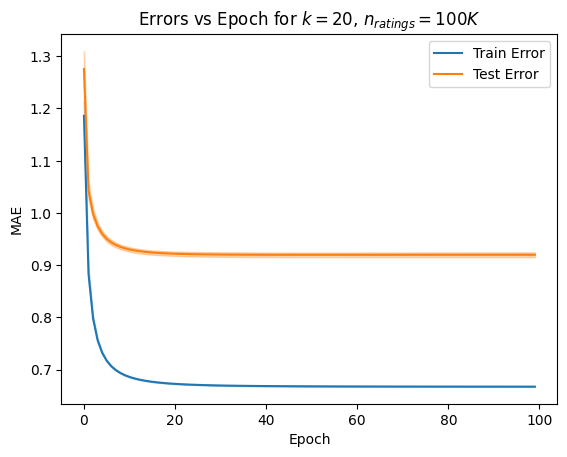

In [12]:
#Epoch에 따른 학습셋과 테스트셋의 에러 평균, 표준편차(그래프 음영)를 그래프로 확인
train_avg, train_std = train_errs.mean(axis=0), train_errs.std(axis=0)
test_avg, test_std = test_errs.mean(axis=0), test_errs.std(axis=0)

l, = plt.plot(np.arange(max_epochs), train_avg, label='Train Error')
plt.fill_between(np.arange(max_epochs), train_avg-train_std, train_avg+train_std,
                 color=l.get_color(), alpha=0.3)

l, = plt.plot(np.arange(max_epochs), test_avg, label='Test Error')
plt.fill_between(np.arange(max_epochs), test_avg-test_std, test_avg+test_std,
                 color=l.get_color(), alpha=0.3)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title(r'Errors vs Epoch for $k=20$, $n_{ratings}=100K$')
plt.show()

* 15 or 20 epochs seems like enough for Test Error to start plateauing.  (15~20 epoch에서부터 테스트 에러가 안정수준 도달로 보임)

# 5. Find Optimal  k (최적의 분해(잠재의미) 차원수 결정)

In [13]:
n_splits = 5
max_epochs = 15
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
k_list = [1, 2, 5, 10, 20, 50, 100]
small_df = ratings_df.iloc[:100000]             # ? 원래 10만개인데.
# 에러 초기화
train_errs = np.zeros((n_splits, len(k_list)))
test_errs = np.zeros((n_splits, len(k_list)))

for i_fold, (train_inds, test_inds) in enumerate(kf.split(small_df)):
    print("i_fold={}: ".format(i_fold), end='')
    train_df, test_df = small_df.iloc[train_inds], small_df.iloc[test_inds]
    baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
    # k를 바꿔가며 test, train error를 저장
    for i_k, k in enumerate(k_list):
        print("k={}, ".format(k), end='')
        rec = ALSRecommender(k=k, baseline_algo=baseline_algo, verbose=False, max_epochs=max_epochs)
        rec.fit(train_df)
        preds = rec.predict(test_df[['userId', 'movieId']])
        test_err = np.sqrt( mean_squared_error(preds, test_df['rating']) )
        test_errs[i_fold, i_k] = test_err
        train_errs[i_fold, i_k] = rec.train_errors[-1]
    print()

i_fold=0: k=1, k=2, k=5, k=10, k=20, k=50, k=100, 
i_fold=1: k=1, k=2, k=5, k=10, k=20, k=50, k=100, 
i_fold=2: k=1, k=2, k=5, k=10, k=20, k=50, k=100, 
i_fold=3: k=1, k=2, k=5, k=10, k=20, k=50, k=100, 
i_fold=4: k=1, k=2, k=5, k=10, k=20, k=50, k=100, 


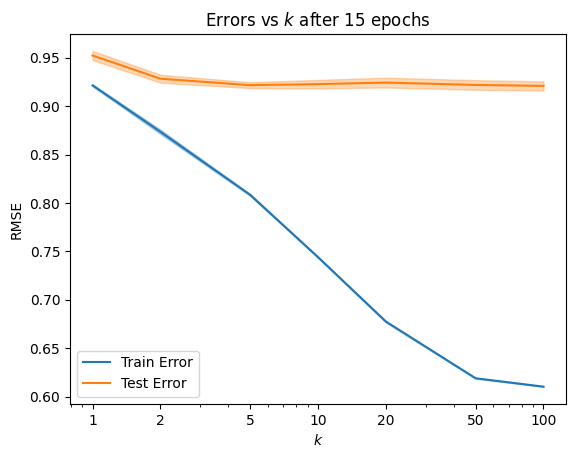

In [14]:
# k변화에 따른 학습셋과 테스트셋의 에러 평균, 표준편차(그래프 음영)를 그래프로 확인
train_avg, train_std = train_errs.mean(axis=0), train_errs.std(axis=0)
test_avg, test_std = test_errs.mean(axis=0), test_errs.std(axis=0)
l, = plt.semilogx(k_list, train_avg, label='Train Error')
plt.fill_between(k_list, train_avg-train_std, train_avg+train_std,
                 color=l.get_color(), alpha=0.3)
l, = plt.semilogx(k_list, test_avg, label='Test Error')
plt.fill_between(k_list, test_avg-test_std, test_avg+test_std,
                 color=l.get_color(), alpha=0.3)
plt.xticks(k_list, k_list)
plt.legend()
plt.xlabel(r'$k$')
plt.ylabel('RMSE')
plt.title(r'Errors vs $k$ after {} epochs'.format(max_epochs))
plt.show()

- k=2 초과하면서부터 대략적인 최소 Test Error에 도달한다.